# Expectation Maximisation for GMM

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import Bounds

In [2]:
def multinomial_sample(p):
    """Sample from a multinomial distribution."""
    
    return np.where(stats.multinomial(1, p).rvs()[0] == 1)[0][0]

In [3]:
def generate_GMM_samples(n, mu, sigma, p):
    """Generate sample from a Gaussian Mixture Model."""
    
    # Preconditions
    assert n > 0, f"Number of samples must be > 0"
    assert len(mu) >= 2
    assert len(sigma) >= 2
    assert len(mu) == len(sigma) == len(p)
    assert all([0 <= pi <= 1 for pi in p])
    
    x = np.zeros(n)
    
    for i in range(n):
        j = multinomial_sample(p)
        x[i] = stats.norm(mu[j], sigma[j]).rvs()
    
    return x

In [215]:
# Number of samples
n = 1000

mu = [5, 15]
sigma = [1, 2]
p = [0.3, 0.7]

In [216]:
samples = generate_GMM_samples(n, mu, sigma, p)

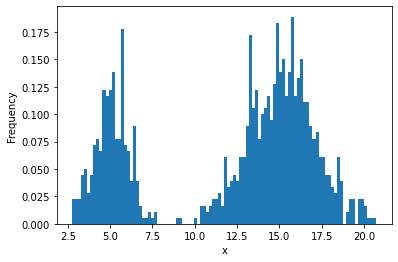

In [217]:
plt.hist(samples, bins=100, density=True)
plt.xlabel('x')
plt.ylabel('Frequency')
plt.show()

In [234]:
# Initial values of the parameters
k = 2  # number of components
w_est = np.array([0.5, 0.5])  # weights for each component 
mu_est = np.array([4.0, 12.0])  # means of the normal distributions
sigma_est = np.array([1.0, 1.0])  # std. devs for the normal distributions

In [235]:
# Stop iterations if the log-likelihood is stabilising
log_likelihoods = []
stopping_criteria_met = False
n_iterations = 0
max_iterations = 20

while not stopping_criteria_met:
 
    n_iterations += 1

    # E-STEP
    # Mean and standard deviation for the components are fixed
    W = np.zeros((n, k))
    
    for i in range(n):
        for j in range(k):
            v = stats.norm(mu_est[j], sigma_est[j]).pdf(samples[i])
            if v == 0:
                v = np.finfo(float).eps
            
            W[i,j] = v

        # Normalise each row to sum to 1
        W[i,:] = W[i,:] / np.sum(W[i,:])

    # Estimate the probability of each class
    total = np.sum(W, axis=0)
    phi = total / np.sum(total)

    # M-STEP
    # Update mu and sigma for fixed weights
    for j in range(k):
        total_weight = np.sum(W[:,j])
        mu_est[j] = (1.0/total_weight) * np.sum(W[:,j] * samples)
        sigma_est[j] = np.sqrt((1.0/total_weight) * np.sum(W[:,j] * (samples - mu_est[j])**2))
        
    # Calculate the log-likelihood of the data given the model
    log_likelihood = 0
    for i in range(n):
        
        total = 0
        for j in range(k):
            v = phi[j] * stats.norm(mu_est[j], sigma_est[j]).pdf(samples[i])
            if v == 0:
                v = np.finfo(float).eps
            total += np.log(v)
        
        if total == 0:
            total = np.finfo(float).eps
        log_likelihood += total
    
    log_likelihoods.append(log_likelihood)
    
    if n_iterations > 1:
        diff = np.abs(log_likelihoods[-1] - log_likelihoods[-2])
        stopping_criteria_met = diff < 1e-3
        print(f"Converged after {n_iterations} iterations")
    
    if not stopping_criteria_met and n_iterations == max_iterations:
        stopping_criteria_met = True
        print(f"Warning: Failed to converge after {n_iterations} iterations")

Converged after 2 iterations
Converged after 3 iterations
Converged after 4 iterations
Converged after 5 iterations
Converged after 6 iterations
Converged after 7 iterations
Converged after 8 iterations


In [236]:
log_likelihoods

[-46545.580429247646,
 -46166.86308990954,
 -46135.41954443654,
 -46132.837170527266,
 -46132.62535670767,
 -46132.60798481532,
 -46132.60656007173,
 -46132.60644322249]

In [237]:
phi

array([0.29614336, 0.70385664])

In [238]:
mu_est

array([ 5.08496671, 15.14964944])

In [239]:
sigma_est

array([0.99092047, 1.990995  ])

In [240]:
x_values = np.arange(0, 23, 0.05)
component_pdfs = np.zeros((k, len(x_values)))

for j in range(k):
    component_pdfs[j,:] = [phi[j] * stats.norm(mu_est[j], sigma_est[j]).pdf(xi) for xi in x_values]

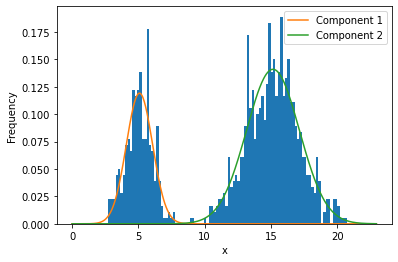

In [241]:
plt.hist(samples, bins=100, density=True)

for j in range(k):
    plt.plot(x_values, component_pdfs[j,:], label=f"Component {j+1}")
    
plt.xlabel('x')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Using BFGS

In [7]:
def calc_gamma(y, w, mu, sigma):
    """Calculate the probability that the i(th) sample belongs to the j(th) component."""
    
    # Preconditions
    assert len(y) > 0
    assert len(w) == len(mu) == len(sigma)
    
    # Number of samples
    n = len(y)
    
    # Number of components
    k = len(mu)
    
    # Matrix to hold the likelihood
    gamma = np.zeros((n, k))
    
    for i in range(n):
        for j in range(k):
            gamma[i,j] = w[j] * stats.norm(mu[j], sigma[j]).pdf(y[i])
    
            # Normalise the row
            # (Probability that the sample belongs to each component must sum to 1)
            total = np.sum(gamma[i,:])
            gamma[i,:] = gamma[i,:] / total
    
    # Return the likelihood matrix
    return gamma

In [8]:
def build_M_step_function(y, gamma, w):
    """Constructor function for the M step in EM."""
    
    # Number of samples
    n = len(y)
    
    # Number of components
    k = len(w)
    
    def m_step(params):
    
        # Preconditions
        assert len(params) == 2*k, f"Expected {2*k} params, got {len(params)}"
        
        # Extract the mu and sigma parameters
        mu, sigma = params[:k], params[k:]
        
        total = 0      
        for j in range(k):
            
            #dist = stats.norm(mu[j], sigma[j])
            
            for i in range(n):
                
                v = w[j] * stats.norm(mu[j], sigma[j]).pdf(y[i])
                
                if v == 0:
                    v = np.finfo(float).eps
                
                total = total + gamma[i,j] * np.log(v)
                
        # Return the sum of the log likelihoods
        # Invert because the function is being maximised, but the optimisation
        # function is minimising
        return -total
    
    # Return the M step function
    return m_step

In [9]:
# Initial values of the parameters
k = 2
w_m = np.array([0.5, 0.5])
mu_m = np.array([3, 9])
sigma_m = np.array([1.0, 1.0])

mu_min = 0.0
mu_max = 20.0
sigma_min = 0.01
sigma_max = 4.0

In [10]:
# Build the bounds array
lower = np.concatenate([np.repeat(mu_min, k), np.repeat(sigma_min, k)])
upper = np.concatenate([np.repeat(mu_max, k), np.repeat(sigma_max, k)])
bounds = Bounds(lower, upper)

In [11]:
print(lower)
print(upper)
print(bounds)

[0.   0.   0.01 0.01]
[20. 20.  4.  4.]
Bounds(array([0.  , 0.  , 0.01, 0.01]), array([20., 20.,  4.,  4.]))


In [12]:
q = []

diff = np.inf

while diff > 1e-3:

    gamma_m = calc_gamma(samples, w_m, mu_m, sigma_m)

    # Calculate the new weights
    n_j_m = np.sum(gamma_m, axis=0)  # sum of each column
    w_m = n_j_m / np.sum(n_j_m)      # normalise

    # Perform the M step
    m_func = build_M_step_function(samples, gamma_m, w_m)
    
    x0 = np.concatenate([mu_m, sigma_m])
    fit = minimize(m_func, 
                   x0,
                   method='L-BFGS-B', 
                   bounds=bounds,
                   options={'disp': True})
    
    # Best value of mu and sigma
    mu_m, sigma_m = fit.x[:k], fit.x[k:]
    
    q.append(fit.fun)
    
    if len(q) < 2:
        diff = np.inf
    else:
        diff = np.abs(q[-1] - q[-2])
    
    print(diff)
    print(mu_m), print(sigma_m), print(w_m)
    print("--")

inf
[11.77036838  9.08402821]
[4.         1.72248878]
[0.9979884 0.0020116]
--
12.83976577639396
[11.7650337  8.8799906]
[4.         3.09977266]
[9.99970121e-01 2.98789985e-05]
--
0.3147391239645003
[11.76495481  8.8799906 ]
[4.         3.09977778]
[9.99998881e-01 1.11887024e-06]
--
0.015607456962698052
[11.76495536  8.8799906 ]
[4.         3.09977778]
[9.99999958e-01 4.18981419e-08]
--
0.0007169245072873309
[11.76495637  8.8799906 ]
[4.         3.09977778]
[9.99999998e-01 1.56895264e-09]
--


In [13]:
x_values = np.arange(0, 23, 0.05)
pdf_comp1 = [w_m[0] * stats.norm(mu_m[0], sigma_m[0]).pdf(xi) for xi in x_values]
pdf_comp2 = [w_m[1] * stats.norm(mu_m[1], sigma_m[1]).pdf(xi) for xi in x_values]

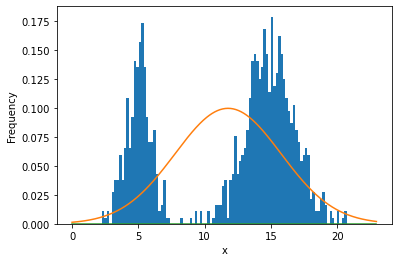

In [14]:
plt.hist(samples, bins=100, density=True)
plt.plot(x_values, pdf_comp1, label="Component 1")
plt.plot(x_values, pdf_comp2, label="Component 2")
plt.xlabel('x')
plt.ylabel('Frequency')
plt.show()